# 5. Advanced Learning Rate Optimization

## What types of hyperparameters are there?
- Learning rate
- Batch size
- Weight decay
- Dropout
- And more!

## Why the concentration on learning rate?
- It's one of the most important hyperparameter that, if properly tuned gives 2 main benefits:
    - Better generalization (higher validation and test accuracy)
    - Faster convergence (less time spent on training)
    
## We've learnt 2 basic ways to optimize learning rate
1. Step-wise Decay 
2. Reduce on Loss Plateau Decay

## 2 new advanced learning rate optimization
- SGD restarts with snapshots
    - This ultimately is heuristic-based
- SGD hypergradient descent
    - This is very diferrent from the basic ways and the advanced SGD restarts with snapshots where they all rely on heuristics
    - It deploys a disciplined approach by using gradient descent to optimize both parameters and hyperparameters

## 1. SGD Restarts with warm restarts
- **Problem**
    - With a larger model capacity (more layers and more complex), more number of local minima with different generalization ability
    - Taking a snapshot of the model at different local minima and combining them gives us an ensemble of models for free  
- **Benefits**
    - Warm restart in optimization allows us to improve generalization
        - Allows us to escape bad local minima
        - Allows us to explore wider loss surface
- **How**
    - Let the learning rate decay then restarting it to a high learning rate when it converges to a local minima
        - Using cosine annealing to decay our learning rate
        - $\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +\cos(\frac{T_{cur}}{T_{max}}\pi))$
            - $\eta_{min}$: Minimum learning rate
            - $\eta_{max}$: Maximum learning rate
            - $T_{max}$: Maximum number of epochs
            - $T_{cur}$: Current epoch
    - Before each reset, snapshot (save) the model's parameters via a checkpoint
    - When we've cycled through our snapshots, we can average the models' softmax outputs to obtain a final averaged categorical distribution (probability distribution over N possible outcomes)
        - Given:
            - $x$ as the input
            - $m$ as the last m model's softmax outputs
            - $h_i (x)$ as the softmax output of snapshot $i$
        - Then the ensemble's output is $h_{ensemble} = \frac{1}{m} \sum^{m-1}_0 h_{i} (x)$ which is simply the average of the last $m$ snapshots where we have to choose $m$ 
    - Instead of just choosing the last $m$ models, we can choose m best snapshots which in practical experience, gives better results than just the last $m$ models

In [27]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler
%matplotlib inline

In [42]:
class SGDR(_LRScheduler):
    """Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
        T_mult (float): Increase T_max by a factor of T_mult after every restart to improve performance. Default: 1.
        model (Model): The model to save.
        save_dir (str): Directory to save snapshots. Default: '/'.
        save_model (bool): Saves the model after every restart. Default: True.
    """

    def __init__(self, optimizer, T_max, model, eta_min=0, last_epoch=-1, T_mult=1, save_dir='/', save_model=True):
        
        
        self.T_max = T_max
        self.T_mult = T_mult
        self.Te = self.T_max
        self.eta_min = eta_min
        self.current_epoch = last_epoch
        
        self.model = model
        self.save_dir = save_dir
        self.save_model = save_model
        
        self.lr_history = []
        
        super().__init__(optimizer, last_epoch)

    # Default function given by PyTorch
    def get_lr(self):
        new_lrs = [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.current_epoch / self.Te)) / 2
                for base_lr in self.base_lrs]
        
        # Append learning rates to tracker so we can print the behavior
        self.lr_history.append(new_lrs)
        return new_lrs
    
    def step(self, epoch=None):
        if epoch is None:
        
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1
        
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
        
        ## restart
        if self.current_epoch == self.Te:
            print("restart at epoch {:03d}".format(self.last_epoch + 1))
            
            if self.save_model:
                torch.save({
                    'epoch': self.T_max,
                    'state_dict': self.model.state_dict()
                }, self.save_dir + "/" + 'snapshot_e_{:03d}.pth.tar'.format(self.T_max))
            
            ## reset epochs since the last reset
            self.current_epoch = 0
            
            ## reset the next goal
            self.Te = int(self.Te * self.T_mult)
            self.T_max = self.T_max + self.Te

In [43]:
class BlankModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 2)
        
    def foward(self, x):
        x = self.fc(x)
        return x

In [44]:
def simulate_lrs(t_max, t_mult, epochs):
    model = BlankModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    sgdr = SGDR(optimizer, T_max=t_max, T_mult=t_mult, model=model, save_dir='blank', save_model=False, eta_min=1e-3)
    
    for i in range(epochs):
        sgdr.step()
        lr = optimizer.param_groups[0]['lr']

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot([x[0] for x in sgdr.lr_history])
    ax.set_yscale("log")
    plt.show()

restart at epoch 010
restart at epoch 020
restart at epoch 030
restart at epoch 040
restart at epoch 050
restart at epoch 060
restart at epoch 070
restart at epoch 080
restart at epoch 090
restart at epoch 100


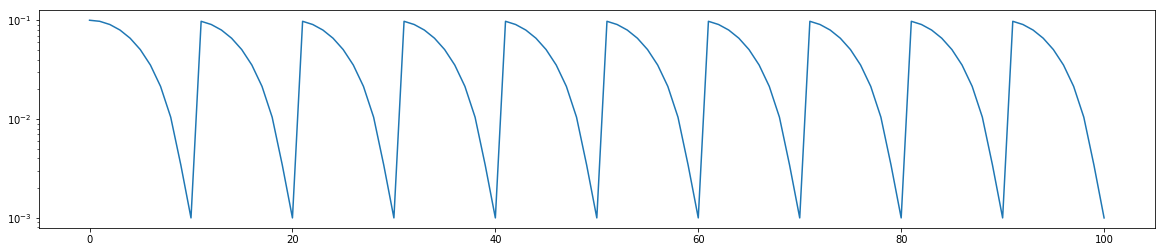

In [45]:
simulate_lrs(10, 1, 100)

## 2. SGD Hypergradient Descent (SGDHD)

### Why do we need SGDHD?
- Typically Snapshots with SGD Restarts would give one of the best results already.
- However, this technique is important because it leverages on the concept of using gradient descent on whatever we want to optimize
    - Be it our parameters or hyperparameters, a non-heuristic approach is in using gradient descent to optimize for everything versus relying on heuristics like (1) step-wise learning rate decay, (3) reduce on plateau loss decay or (3) snapshots with SGD starts
    
### How it works in detail
- Regular update rule: gradient of the lost function w.r.t. parameters
    - We update our old parameters with the loss w.r.t. parameters
    - $\theta_t = \theta_{t-1} - \alpha \nabla f (\theta_{t-1})$
        - Parameters $\theta_{t-1}$
        - Objective function $f$
        - Gradient $\nabla f (\theta_{t-1})$
        - Learning rate $\alpha$
- Additional update rule for learning rate: partial derivative of the lost function w.r.t. learning rate
    - $\alpha_t = \alpha_{t-1} - \beta \frac {\partial f(\theta_{t-1})}{\partial \alpha}$
        - Hyper learning rate $\beta$

In [7]:
import torch
from functools import reduce
from torch.optim.optimizer import Optimizer, required


class SGDHD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        hypergrad_lr (float, optional): hypergradient learning rate for the online
        tuning of the learning rate, introduced in the paper
        `Online Learning Rate Adaptation with Hypergradient Descent`_
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. _Online Learning Rate Adaptation with Hypergradient Descent:
        https://openreview.net/forum?id=BkrsAzWAb
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v
        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
             v = \rho * v + lr * g \\
             p = p - v
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, hypergrad_lr=1e-6):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, hypergrad_lr=hypergrad_lr)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGDHD, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("SGDHD doesn't support per-parameter options (parameter groups)")

        self._params = self.param_groups[0]['params']
        self._params_numel = reduce(lambda total, p: total + p.numel(), self._params, 0)

    def _gather_flat_grad_with_weight_decay(self, weight_decay=0):
        views = []
        for p in self._params:
            if p.grad is None:
                view = torch.zeros_like(p.data)
            elif p.grad.data.is_sparse:
                view = p.grad.data.to_dense().view(-1)
            else:
                view = p.grad.data.view(-1)
            if weight_decay != 0:
                view.add_(weight_decay, p.data.view(-1))
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
            offset += numel
        assert offset == self._params_numel

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        loss = None
        if closure is not None:
            loss = closure()

        group = self.param_groups[0]
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']

        grad = self._gather_flat_grad_with_weight_decay(weight_decay)

        # NOTE: SGDHD has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        # State initialization
        if len(state) == 0:
            state['grad_prev'] = torch.zeros_like(grad)

        grad_prev = state['grad_prev']
        # Hypergradient for SGD
        h = torch.dot(grad, grad_prev)
        # Hypergradient descent of the learning rate:
        group['lr'] += group['hypergrad_lr'] * h

        if momentum != 0:
            if 'momentum_buffer' not in state:
                buf = state['momentum_buffer'] = torch.zeros_like(grad)
                buf.mul_(momentum).add_(grad)
            else:
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(1 - dampening, grad)
            if nesterov:
                grad.add_(momentum, buf)
            else:
                grad = buf

        state['grad_prev'] = grad

        self._add_grad(-group['lr'], grad)

        return loss